# Imports

In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
tqdm.pandas()

file_name = "rustavi2_parsed_data.parquet"

In [2]:
df = pd.read_parquet(file_name)

In [3]:
df.head()

,url,title,body,author,scraped_at
0,https://rustavi2.ge/ka/news/19722,"""სახელმწიფო ვერ მოიშორებს პასუხისმგებლობას დაზ...",ვინ აანაზღაურებს სტიქიის დროს დაზიანებული დაუზ...,None,2025-01-05T12:21:03.573389
1,https://rustavi2.ge/ka/news/292280,ანა წითლიძე თანაპარტიელებთან ერთად ზუგდიდის დე...,"""ნაციონალური მოძრაობის"" პოლიტიკური საბჭოს წევრ...",ლიკა ალელიშვილი,2025-01-05T12:21:03.582095
2,https://rustavi2.ge/ka/news/151677,"ახალი გადაცემები, გამოწვევები და რუბრიკები - ""...","""რუსთავი 2"" ახალ წელს ახალი გეგმებით ხვდება. ყ...",None,2025-01-05T12:21:03.591569
3,https://rustavi2.ge/ka/news/247079,"სტამბულში, შვედეთის საკონსულოს წინ აქცია გაიმა...",სტამბულში შვედეთის საკონსულოს წინ აქცია გაიმარ...,None,2025-01-05T12:21:03.600108
4,https://rustavi2.ge/ka/news/17865,"ბიუჯეტის სეკვესტრი - ოპოზიცია ამბობს, რომ საქა...",საქართველოს მთავრობა უკვე მუშაობს ბიუჯეტის კორ...,None,2025-01-05T12:21:03.609244


# Small preprocessing

In [4]:
df['title'] = df['title'].progress_apply(lambda x: x.replace('\xa0', ' '))
df['body'] = df['body'].progress_apply(lambda x: x.replace('\xa0', ' '))

100%|██████████| 293415/293415 [00:00<00:00, 1223622.42it/s]


In [5]:
df.head()

,url,title,body,author,scraped_at
0,https://rustavi2.ge/ka/news/19722,"""სახელმწიფო ვერ მოიშორებს პასუხისმგებლობას დაზ...",ვინ აანაზღაურებს სტიქიის დროს დაზიანებული დაუზ...,None,2025-01-05T12:21:03.573389
1,https://rustavi2.ge/ka/news/292280,ანა წითლიძე თანაპარტიელებთან ერთად ზუგდიდის დე...,"""ნაციონალური მოძრაობის"" პოლიტიკური საბჭოს წევრ...",ლიკა ალელიშვილი,2025-01-05T12:21:03.582095
2,https://rustavi2.ge/ka/news/151677,"ახალი გადაცემები, გამოწვევები და რუბრიკები - ""...","""რუსთავი 2"" ახალ წელს ახალი გეგმებით ხვდება. ყ...",None,2025-01-05T12:21:03.591569
3,https://rustavi2.ge/ka/news/247079,"სტამბულში, შვედეთის საკონსულოს წინ აქცია გაიმა...",სტამბულში შვედეთის საკონსულოს წინ აქცია გაიმარ...,None,2025-01-05T12:21:03.600108
4,https://rustavi2.ge/ka/news/17865,"ბიუჯეტის სეკვესტრი - ოპოზიცია ამბობს, რომ საქა...",საქართველოს მთავრობა უკვე მუშაობს ბიუჯეტის კორ...,None,2025-01-05T12:21:03.609244


# Counting words and chars 

In [6]:
df['words_count'] = df.progress_apply(lambda x: len((x['title'] + '\n' + x['body']).split()), axis=1)
df['chars_count'] = df.progress_apply(lambda x: len(x['title'] + '\n' + x['body']), axis=1)

print(f"Total number of words are {df['words_count'].sum()}")
print(f"Total number of chars are {df['chars_count'].sum()}")

100%|██████████| 293415/293415 [00:01<00:00, 291871.27it/s]

Total number of words are 38407510
Total number of chars are 344787359


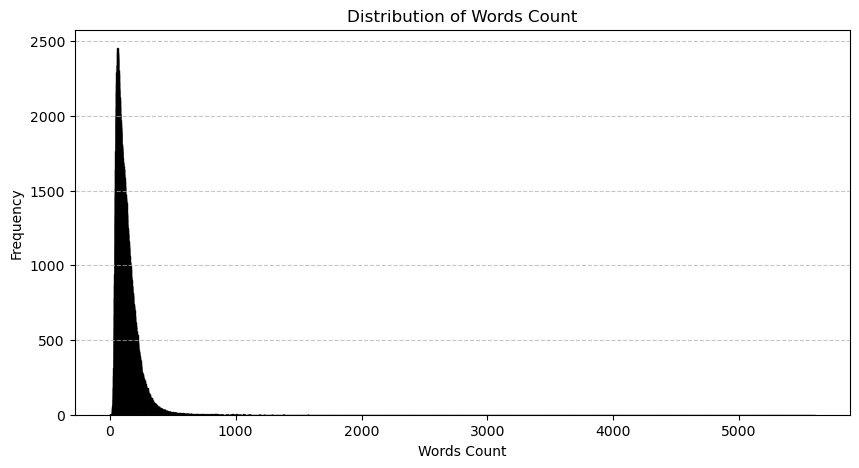

In [7]:
# Plot 1: Distribution of `words_count`
plt.figure(figsize=(10, 5))
plt.hist(df["words_count"], bins=range(df["words_count"].min(), df["words_count"].max() + 2), edgecolor='black', align='left')
plt.title("Distribution of Words Count")
plt.xlabel("Words Count")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

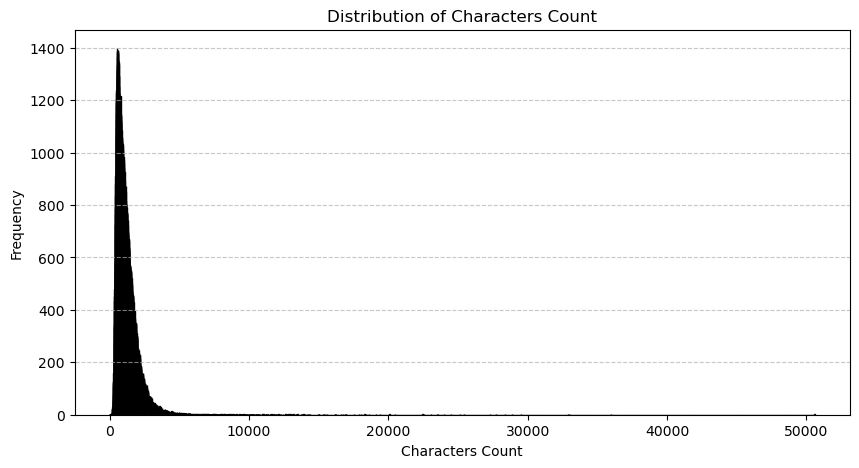

In [8]:
# Plot 2: Distribution of `chars_count`
plt.figure(figsize=(10, 5))
plt.hist(df["chars_count"], bins=range(df["chars_count"].min(), df["chars_count"].max() + 2, 5), edgecolor='black', align='left')
plt.title("Distribution of Characters Count")
plt.xlabel("Characters Count")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Printing outliers

In [9]:
def find_outliers_df(df, column_name):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    # Calculate IQR
    IQR = Q3 - Q1
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter DataFrame for outliers
    outliers_df = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    return outliers_df

# Find outliers for `words_count`
words_outliers_df = find_outliers_df(df, "words_count")

# Find outliers for `chars_count`
chars_outliers_df = find_outliers_df(df, "chars_count")

# Combine both to see all outliers in a single DataFrame
extreme_values_df = pd.concat([words_outliers_df, chars_outliers_df]).drop_duplicates()

In [10]:
extreme_values_df.sort_values(by="chars_count", ascending=False).head()

,url,title,body,author,scraped_at,words_count,chars_count
197364,https://rustavi2.ge/ka/news/247198,არ გვახსენდება არც ერთი სტატუსი თუ მოწოდება ხე...,"""ხალხის ძალის"" წევრი ზურაბ ქადაგიძე სოციალურ ქ...",None,2025-01-05T12:21:45.424713,5599,50592
8340,https://rustavi2.ge/ka/news/187023,ბიძინა ივანიშვილი პოლიტიკიდან მიდის,ქართული ოცნების“ თავმჯდომარე ბიძინა ივანიშილი ...,None,2025-01-05T12:28:57.396893,4178,35965
56976,https://rustavi2.ge/ka/news/13818,პატრიარქის სააღდგომო ეპისტოლე გამოქვეყნდა,"საქართველოს საპატრიარქომ, სრულიად საქართველოს ...",None,2025-01-05T12:25:15.723070,4174,32940
279815,https://rustavi2.ge/ka/news/13819,პატრიარქის სააღდგომო ეპისტოლე გამოქვეყნდა,"საქართველოს საპატრიარქომ, სრულიად საქართველოს ...",None,2025-01-05T12:21:34.732004,4171,32909
76470,https://rustavi2.ge/ka/news/295936,არჩევნები საერთო საქმეა - 2 დღე ქვეყნისთვის უმ...,26 ოქტომბერს გაიმართება საქართველოს პარლამენტი...,None,2025-01-05T12:27:39.454129,3279,29536


In [11]:
extreme_values_df.sort_values(by="words_count", ascending=False).head()

,url,title,body,author,scraped_at,words_count,chars_count
197364,https://rustavi2.ge/ka/news/247198,არ გვახსენდება არც ერთი სტატუსი თუ მოწოდება ხე...,"""ხალხის ძალის"" წევრი ზურაბ ქადაგიძე სოციალურ ქ...",None,2025-01-05T12:21:45.424713,5599,50592
8340,https://rustavi2.ge/ka/news/187023,ბიძინა ივანიშვილი პოლიტიკიდან მიდის,ქართული ოცნების“ თავმჯდომარე ბიძინა ივანიშილი ...,None,2025-01-05T12:28:57.396893,4178,35965
56976,https://rustavi2.ge/ka/news/13818,პატრიარქის სააღდგომო ეპისტოლე გამოქვეყნდა,"საქართველოს საპატრიარქომ, სრულიად საქართველოს ...",None,2025-01-05T12:25:15.723070,4174,32940
279815,https://rustavi2.ge/ka/news/13819,პატრიარქის სააღდგომო ეპისტოლე გამოქვეყნდა,"საქართველოს საპატრიარქომ, სრულიად საქართველოს ...",None,2025-01-05T12:21:34.732004,4171,32909
262871,https://rustavi2.ge/ka/news/302780,თანამედროვე ქართული სპორტის ისტორიაში საუკეთეს...,2024 წელი - თანამედროვე ქართული ფეხბურთის ისტო...,None,2025-01-05T12:24:24.040819,3459,28906


In [12]:
extreme_values_df.sort_values(by="chars_count").head()

,url,title,body,author,scraped_at,words_count,chars_count
273949,https://rustavi2.ge/ka/news/198212,"""რა ვიცი რომ ივერის მხრიდან პროვოკაცია არ იყო,...",ბოდბელი ეპისკოპოსი იაკობი ივერი მელაშვილსა და ...,ნათია წითელაური,2025-01-05T12:28:31.437676,315,2089
231583,https://rustavi2.ge/ka/news/185351,ბოლო 24 საათში ქვეყნის მასშტაბით ჩატარდა 9 812...,ქვეყანაში ინტენსიური ტესტირების ფარგლებში ბოლო...,None,2025-01-05T12:26:11.174690,319,2154
36793,https://rustavi2.ge/ka/news/208762,"კახისთან შეხვედრა არ უარვყავი, მაგრამ ვერც სიმ...",თბილისის მერობის კანდიდატმა და ყოფილმა პრემიერ...,None,2025-01-05T12:21:16.998448,310,2168
130550,https://rustavi2.ge/ka/news/81319,გამოკითხულთა 16% სიტყვის თავისუფლების კუთხით ა...,ეროვნულ-დემოკრატიული ინსტიტუტი დღეს საზოგადოებ...,None,2025-01-05T12:25:47.147939,317,2176
59802,https://rustavi2.ge/ka/news/41745,ინგა გრიგოლიას პირადი ცხოვრების კადრების გასაჯ...,ჟურნალისტ და ტელეწამყვან ინგა გრიგოლიას პირადი...,None,2025-01-05T12:21:31.730212,312,2214


In [13]:
extreme_values_df.sort_values(by="words_count").head()

,url,title,body,author,scraped_at,words_count,chars_count
154986,https://rustavi2.ge/ka/news/169698,ჩინეთში კაცობრიობის ისტორიაში ყველაზე მომაკვდი...,"ცხელება, სუნთქვის გართულებული ფორმები და პნევმ...",ელიტა ანდღულაძე,2025-01-05T12:28:56.984142,210,2757
20335,https://rustavi2.ge/ka/news/73258,აღდგომის ღამეს მეტრო 16 აპრილის 04:00 საათამდე...,"აღდგომის დღესასწაულთან დაკავშირებით, მეტრო 16 ...",None,2025-01-05T12:25:09.953023,212,2810
226967,https://rustavi2.ge/ka/news/269429,სილქ როუდ ჯგუფს საქართველოში ჰოლივუდის კინომწა...,"სილქ როუდ ჯგუფმა, ამერიკულმა კინოსტუდიამ Wonde...",None,2025-01-05T12:26:07.994680,214,2859
4328,https://rustavi2.ge/ka/news/245001,მასშტაბური სპეცოპერაცია თბილისსა და რეგიონებში...,სამართალდამცველებს საგამოძიებო მოქმედებების ჩა...,ნათია მღებრიშვილი,2025-01-05T12:29:41.230634,216,2812
144661,https://rustavi2.ge/ka/news/227291,76 წლის რუსი ქალი პუტინის რეჟიმს მარტო ებრძვის...,"76 წლის რუსი ქალი, რომელიც პუტინის რეჟიმს მარტ...",None,2025-01-05T12:26:36.118396,224,2805


# Words Length Distributions

In [14]:
# Tokenize words and calculate word lengths
all_words = [word for sentence in (df["title"] + ' ' + df['body']) for word in sentence.split()]
word_lengths = [len(word) for word in all_words]

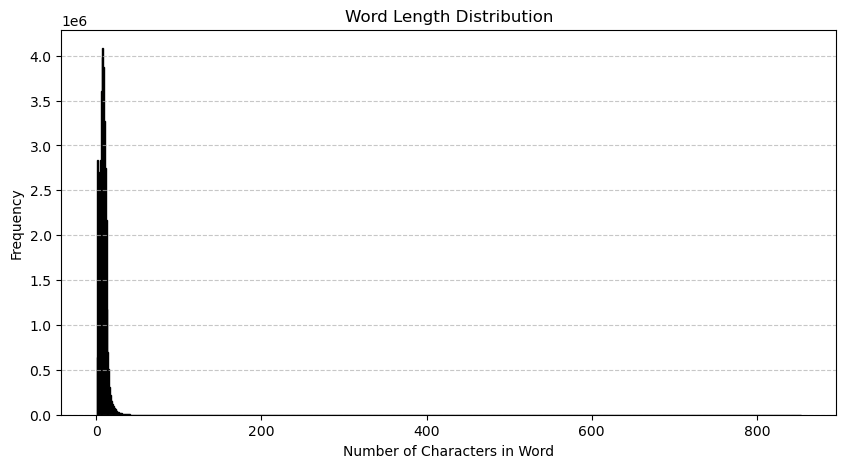

In [15]:
# Plot Word Length Distribution
plt.figure(figsize=(10, 5))
plt.hist(word_lengths, bins=range(1, max(word_lengths) + 1), edgecolor='black', align='left')
plt.title("Word Length Distribution")
plt.xlabel("Number of Characters in Word")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
# Combine words with their lengths
word_length_pairs = list(zip(all_words, word_lengths))


# Sort by word length in descending order
sorted_word_length_pairs = sorted(word_length_pairs, key=lambda x: x[1], reverse=True)

# Print top highest words with their lengths
top_n = 10  # Number of top longest words to display
print(f"Top {top_n} longest words with their lengths:")
for word, length in sorted_word_length_pairs[:top_n]:
    print(f"{word}: {length}")

Top 10 longest words with their lengths:
450მაორგანიზაციამმიმართაიუსტიციისსამინისტროსდაამფონზეკიდევუფროშეუძლებელიგახდასარჩელისწარმატება.„ვფიქრობ,არავითარიპერსპექტივაამსარჩელსარცმანამდეჰქონდადაახლამითუმეტესარაქვს,ამასდაემატაახლაუკვე„სირცხვილიას“აღიარება,ამასდაემატა450ორგანიზაციისმიმართვაიუსტიციისსამინისტროსადმი,ამფონზეკიდევუფროშეუძლებელიგახდაამსარჩელისწარმატება.რეალურადყველაფრითდამტკიცდა,რომარცსტიგმატიზაციისადაარცშეზღუდვებისპრობლემაარარსებობს.როგორშეიძლება,გაასაჩივროკანონი,რომელიცითვალისწინებსერთადერთრამეს-ხარორგანიზაცია,რომელიციღებდაფინანსებას20პროცენტზემეტსუცხოეთიდან,მიმართავიუსტიციისსამინისტროსერთადერთიმოთხოვნით,რომშენიინფორმაციადაფინანსებისთაობაზევებგვერდზედაიდოსდაამაზესაუბრობენ,რომარისრუსული,საშინელიკანონიდაორგანიზაციებსგააუქმებსდაა.შ.როგორშეიძლება,ასეთსარჩელსჰქონდესრაიმეწარმატება,სრულიაბსურდიაესყველაფერი.შესაბამისად,მეძალიანსკეპტიკურადვარგანწყობილიამსარჩელისპერსპექტივისმიმართ“,: 854
-განაცხადაპრემიერ-მინისტრმა.მისივეთქმით,მოსარჩელეებისრაოდენობაარისერთპროცენტზებევრადნაკლებიდასიცრუე

# Wordclouds

In [18]:
# Combine title and body into a single text
text = " ".join(df["title"] + ' ' + df["body"])

# Initialize CountVectorizer for bigrams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))
bigram_counts = bigram_vectorizer.fit_transform([text])

# Initialize CountVectorizer for trigrams
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))
trigram_counts = trigram_vectorizer.fit_transform([text])

# Convert bigram counts to a dictionary
bigram_counts_dict = dict(zip(bigram_vectorizer.get_feature_names_out(), bigram_counts.toarray()[0]))

# Convert trigram counts to a dictionary
trigram_counts_dict = dict(zip(trigram_vectorizer.get_feature_names_out(), trigram_counts.toarray()[0]))

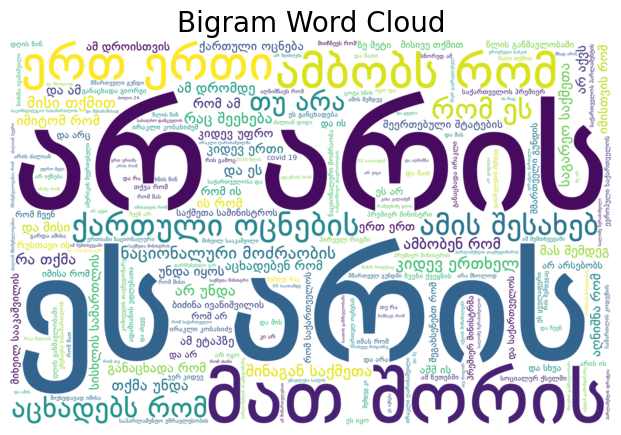

In [19]:
# Generate the word cloud
bigram_wordcloud = WordCloud(background_color='white', width=1600, height=1024, font_path='./bpg_dejavu_sans.otf').generate_from_frequencies(bigram_counts_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(bigram_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Bigram Word Cloud", fontsize=20)
plt.show()

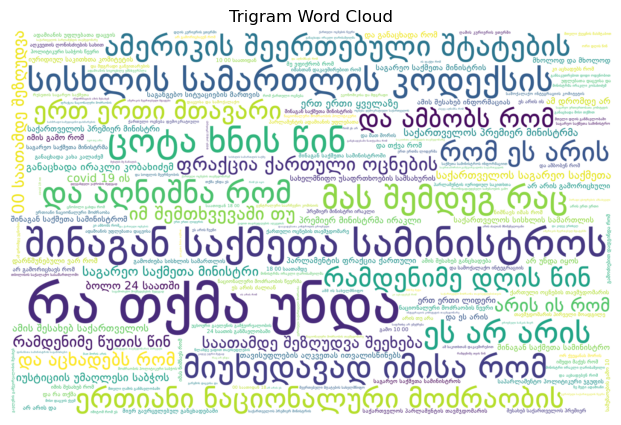

In [20]:
# Generate word cloud for trigrams
trigram_wordcloud = WordCloud(background_color='white', width=1600, height=1024, font_path='./bpg_dejavu_sans.otf').generate_from_frequencies(trigram_counts_dict)

plt.figure(figsize=(10, 5))
plt.imshow(trigram_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Trigram Word Cloud")
plt.show()